In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

sns.set_style("white")

import re
from plotnine import *
import scipy
from tqdm import tqdm
import time
from sklearn.mixture import GaussianMixture

In [2]:
df= pd.read_csv('steam-200k-cleaned.csv')
df_train = pd.read_csv('steam-200k-cleaned_train.csv')
df_test = pd.read_csv('steam-200k-cleaned_test.csv')

In [3]:
game_freq = df_train.groupby(by='game').agg({'user': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='user',ascending=False)[:20].reset_index()
print(top20)
df_train['user']=df_train['user'].astype(int)
df['user']=df['user'].astype(int)
df_test['user']=df_test['user'].astype(int)

    index                                          game  user     hours
0    1269                                        Dota 2  3849  752245.5
1    4041                               Team Fortress 2  1874  144490.8
2    4553                                      Unturned  1225   12422.1
3     924               Counter-Strike Global Offensive  1115  266537.3
4    1966                        Half-Life 2 Lost Coast   798     160.1
5     927                         Counter-Strike Source   791   81249.1
6    2341                                 Left 4 Dead 2   759   22895.1
7     921                                Counter-Strike   699  104818.2
8    4661                                      Warframe   678   22665.7
9    1963                        Half-Life 2 Deathmatch   662    2847.2
10   1799                                   Garry's Mod   596   42463.6
11   4143                    The Elder Scrolls V Skyrim   574   56490.2
12    922                 Counter-Strike Condition Zero   554   

In [4]:
# Cleaning up the game columns. It doesn't like some of the special characters

df_train['game1'] = df_train['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
df['game1'] = df['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))
df.head()

,user,game,hours,purchase,play,game1
0,5250,Alien Swarm,4.9,1,1,AlienSwarm
1,5250,Cities Skylines,144.0,1,1,CitiesSkylines
2,5250,Counter-Strike,0.0,1,0,CounterStrike
3,5250,Counter-Strike Source,0.0,1,0,CounterStrikeSource
4,5250,Day of Defeat,0.0,1,0,DayofDefeat


### EM Algorithm: Game Hours’ Distribution
The Expectation-Maximization (EM) algorithm is an approach for maximum likelihood estimation in the presence of latent variables. It is an appropriate approach to use to estimate the parameters of a given data distribution.

In order to come up with a rating system (since the user dataset has implicit data), we decided to use the distributions of hours played for each game with the EM algorithm rather than using percentiles.

We create the rating system based on the distribution of hours played, this for each game available in the user dataset. We use 5 groups (equivalent to a 5 stars rating system) in order to define a rating users would give to a game they played based on the hours each one played each game relative to that of everyone else.

Steam allows users to refund games they played for less than 2 hours. We decided to consider this fact for our recommender system. Thus, user-item interactions with less than 2 hours are not considered.

In [5]:
#EM Algorithm based on raw data
def game_hrs_density(GAME, nclass, print_vals=True):
    
    #Ignore the game hrs less than 2 hrs
    game_data = df[(df['game1'] == GAME)&(df['hours']>2)]
    
    #Log hrs
    game_data['loghrs'] = np.log(df['hours'])
    
    #Calculate the mu,sigma to process Gaussian function
    mu_init = np.linspace(min(game_data['loghrs']), max(game_data['loghrs']), nclass).reshape(-1, 1)
    sigma_init = np.array([1] * nclass).reshape(-1, 1, 1)
    gaussian = GaussianMixture(n_components=nclass, means_init=mu_init, precisions_init=sigma_init).fit(game_data['loghrs'].values.reshape([-1, 1]))
    
    #print Gaussian Lambda Mean Sigma
    if print_vals:
        print(' lambda: {}\n mean: {}\n sigma: {}\n'.format(gaussian.weights_, gaussian.means_, gaussian.covariances_))
    
    #Random Generate
    x = np.linspace(min(game_data['loghrs']), max(game_data['loghrs']), 1000)
    
    #Plot
    dens = pd.DataFrame({'x': x})
    for i in range(nclass):
        dens['y{}'.format(i+1)] = gaussian.weights_[i]* scipy.stats.norm(gaussian.means_[i][0], gaussian.covariances_[i][0][0]).pdf(x)
    dens = dens.melt('x', value_name='gaussian')
    
    # Building data frame for plotting
    game_plt = ggplot(aes(x='loghrs', y='stat(density)'), game_data) + geom_histogram(bins=25, colour = "black", alpha = 0.7, size = 0.1) + \
               geom_area(dens, aes(x='x', y='gaussian', fill = 'variable'), alpha = 0.5, position = position_dodge(width=0.2)) + geom_density()+ \
               ggtitle(GAME)
    return game_plt

C:\Users\HP\anaconda3\envs\metis\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
C:\Users\HP\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 lambda: [0.14278986 0.0855019  0.3317454  0.37612749 0.06383534]
 mean: [[1.60095334]
 [2.54910696]
 [3.83540727]
 [4.45166099]
 [4.73113193]]
 sigma: [[[0.16734124]]

 [[0.69745897]]

 [[0.561592  ]]

 [[0.25072252]]

 [[0.13113317]]]



C:\Users\HP\anaconda3\envs\metis\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_dodge requires non-overlapping x intervals


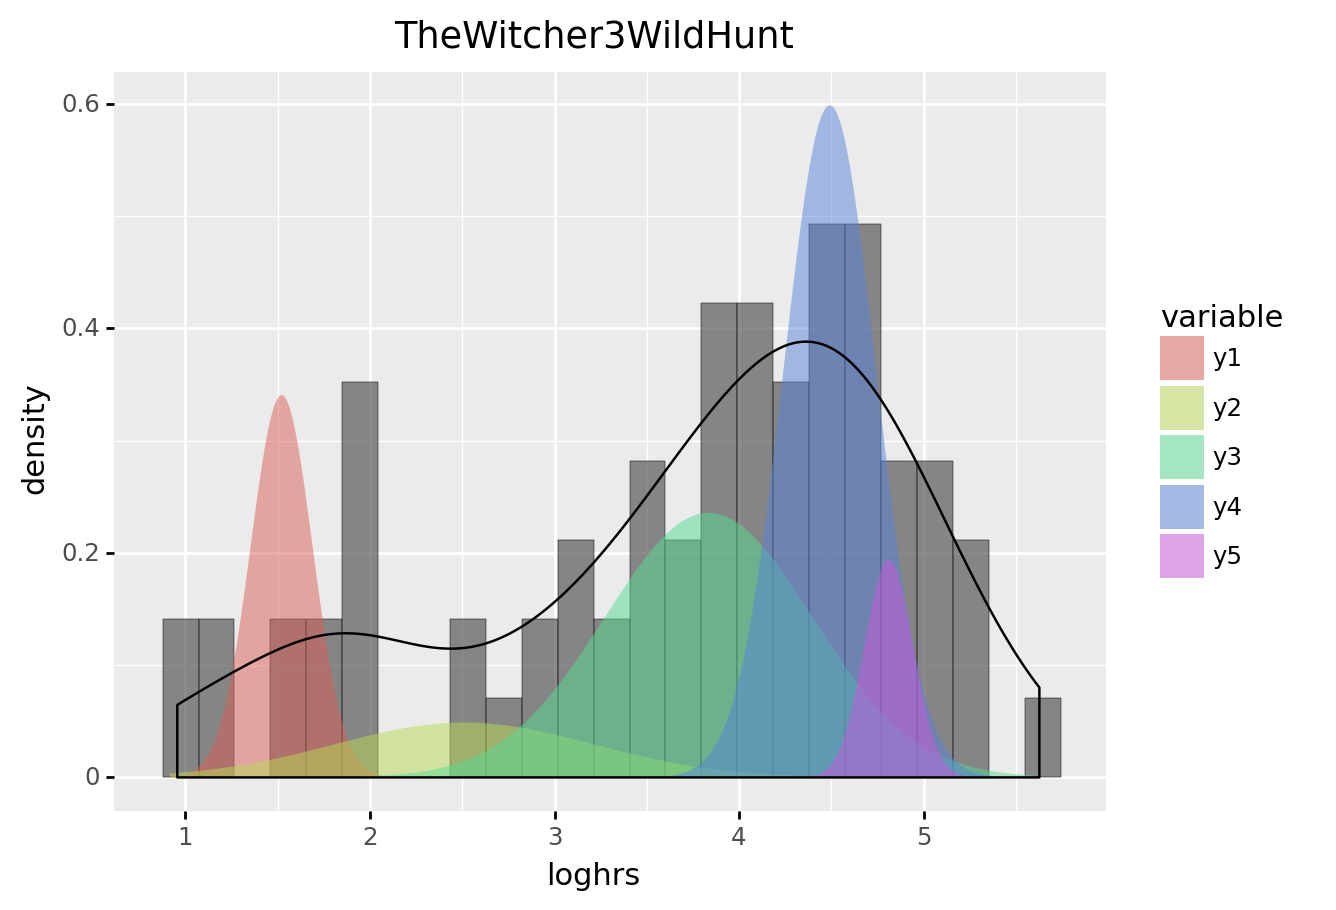

<ggplot: (132033428456)>


In [6]:
#Print one example
a = game_hrs_density('TheWitcher3WildHunt', 5, True)
print(a)

As you can see most of those who played the The Witcher 3 stuck with it and played 40+ hours. However there were a few users where The Witcher didn't grab them and stopped playing after a few hours. The EM algorithm does a great job finding the groups of people with similar gaming habits and would potentially rate the game in a similar way. It does have some trouble converging which isn't surprising however the resulting distributions look very reasonable.

A user-item matrix is created with the users being the rows and games being the columns. The missing values are set to zero. The observed values are the log hours for each observed user-game combination.
The data was subset to games which have greater than 50 users and users which played the game for greater than 2 hours. This was chosen as 2 hours is the limit in which Steam will offer a return if you did not like the purchased game (a shout out to the Australian Competition and Consumer Commission for that one!).

To create a test set 10% of the observed values will be set to 0. The root mean squared error will be calculated to determine the accuracy.

In [7]:
# Create user item matrix
np.random.seed(910)

# Delete unnecessary characters
game_freq['game1'] = game_freq['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))

# Only Consider the games have more than 50 users
game_users = game_freq[game_freq['user'] > 50]

In [8]:
#For whole dataset
steam_clean_pos = df[df['hours'] > 2]
steam_clean_pos_idx = steam_clean_pos['game1'].apply(lambda x: x in game_users['game1'].values)
steam_clean_pos = steam_clean_pos[steam_clean_pos_idx]
steam_clean_pos['loghrs'] = np.log(steam_clean_pos['hours'])

A user-item matrix is created with the users being the rows and games being the columns. The missing values are set to zero. The observed values are the log hours for each observed user-game combination.
The data was subset to games which have greater than 50 users and users which played the game for greater than 2 hours. This was chosen as 2 hours is the limit in which Steam will offer a return if you did not like the purchased game (a shout out to the Australian Competition and Consumer Commission for that one!).

To create a test set 10% of the observed values will be set to 0. The root mean squared error (RSME) will be calculated to determine the accuracy.

In [9]:
# make matrix
games = pd.DataFrame({'game1': sorted(steam_clean_pos['game1'].unique()), 'game_id': range(len(steam_clean_pos['game1'].unique()))})
users = pd.DataFrame({'user': sorted(steam_clean_pos['user'].unique()), 'user_id': range(len(steam_clean_pos['user'].unique()))})
steam_clean_pos = pd.merge(steam_clean_pos, games, on=['game1'])
steam_clean_pos = pd.merge(steam_clean_pos, users, on=['user'])

ui_mat = np.zeros([len(users), len(games)])
for i in range(steam_clean_pos.shape[0]):
    line = steam_clean_pos.iloc[i]
    ui_mat[line['user_id'], line['game_id']] = line['loghrs']

In [10]:
#test dataset user
users_test = pd.DataFrame({'user': sorted(df_test['user'].unique()), 'user_id': range(len(df_test['user'].unique()))})
print(users_test)

           user  user_id
0          5250        0
1         76767        1
2         86540        2
3        103360        3
4        144736        4
...         ...      ...
5843  309262440     5843
5844  309265377     5844
5845  309404240     5845
5846  309434439     5846
5847  309812026     5847

[5848 rows x 2 columns]


In [11]:
# For train dataset
# Only consider the games hrs more than 2 hrs
df_train2 = df_train[df_train['hours'] > 2]
print(df_train2)

#Not consider the games that users less than 50
steam_train_idx = df_train2['game1'].apply(lambda x: x in game_users['game1'].values)
df_train2 = df_train2[steam_train_idx]
df_train2['loghrs'] = np.log(df_train2['hours'])

# Make Matrix
# List the games in train dataset use for recommend
games_train = pd.DataFrame({'game1': sorted(df_train2['game1'].unique()), 'game_id': range(len(df_train2['game1'].unique()))})

# List the users in train dataset use for recommend
users_train = pd.DataFrame({'user': sorted(df_train2['user'].unique()), 'user_id': range(len(df_train2['user'].unique()))})

#Merge the games and users to one data frame
df_train2 = pd.merge(df_train2, games_train, on=['game1'])
df_train2 = pd.merge(df_train2, users_train, on=['user'])

             user                          game  hours  purchase  play  \
0            5250                   Alien Swarm    4.9       1.0   1.0   
5            5250      Deus Ex Human Revolution   62.0       1.0   1.0   
14           5250                      Portal 2   13.6       1.0   1.0   
17          76767  Age of Empires II HD Edition   13.1       1.0   1.0   
21          76767        Call of Duty Black Ops   22.0       1.0   1.0   
...           ...                           ...    ...       ...   ...   
103030  309255941             Mitos.is The Game    5.7       1.0   1.0   
103035  309404240               Team Fortress 2    2.2       1.0   1.0   
103037  309404240                      Unturned   13.0       1.0   1.0   
103038  309554670             Mitos.is The Game    5.9       1.0   1.0   
103039  309626088  Age of Empires II HD Edition    6.7       1.0   1.0   

                          game1  
0                    AlienSwarm  
5         DeusExHumanRevolution  
14       

In [12]:
# Create training set
test=df_train2
ui_train = ui_mat
for i in range(test.shape[0]):
    line = test.iloc[i]
    ui_train[line['user_id'], line['game_id']] = 0
print("Dimensions of training user-item matrix:", ui_train.shape)

Dimensions of training user-item matrix: (8099, 405)


In [13]:
# Root Mean Squared error function, Evaluation metric for SVD
def rmse(pred, test, data_frame=False):
    test_pred = np.array([np.nan] * len(test))
    
    for i in range(len(test)):
        line = test.iloc[i]
        test_pred[i] = pred[line['user_id'], line['game_id']]
    
    if data_frame:
        return pd.DataFrame({'test_pred': test_pred, 'loghrs': test['loghrs']})
    
    return np.sqrt(1/(len(test)-1)*np.sum((test_pred - test['loghrs']) ** 2))

## Basic SVD ##

The basic SVD approach will perform matrix factorisation using the first 60 leading components. Since the missing values are set to 0 the factorisation will try and recreate them which is not quite what we want. For this example we will simply impute the missing observations with a mean value.

In [14]:
# Basic svd
Y = pd.DataFrame(ui_train).copy()

In [15]:
# Impute the missing observations with a mean value
means = np.mean(Y)
for i, col in enumerate(Y.columns):
    Y[col] = Y[col].apply(lambda x: means[i] if x == 0 else x)
U, D, V = np.linalg.svd(Y)
p_df = pd.DataFrame({'x': range(1, len(D)+1), 'y': D/np.sum(D)})

In [16]:
#Set the latent factor as 60
lc = 60
pred = np.dot(np.dot(U[:, :lc], np.diag(D[:lc])), V[:lc, :])
#Calculate rmse
print(rmse(pred, test))
rmse(pred, test, True).head()

3.184696164264591


,test_pred,loghrs
0,-0.077992,1.589235
1,-0.017251,4.127134
2,0.503269,2.610070
3,0.062346,1.335001
4,0.186535,2.667228


In [17]:
#SVD via gradient descent
#Set the latent factor as 60
leading_components=60

In [18]:
# Setting matricies
Y = pd.DataFrame(ui_train)
I = Y.copy()

In [19]:
for col in I.columns:
    I[col] = I[col].apply(lambda x: 1 if x > 0 else 0)
U = np.random.normal(0, 0.01, [I.shape[0], leading_components])
V = np.random.normal(0, 0.01, [I.shape[1], leading_components])
#Squared error
def f(U, V):
    return np.sum(I.values*(np.dot(U, V.T)-Y.values)**2)
def dfu(U):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)), V)
def dfv(V):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)).T, U)

## SVD via gradient descent ##

This example will use a gradient descent approach to find optimal U and V matrices which retain the actual observations with predict the missing values by drawing on the information between similar users and games.
I have chosen a learning rate of 0.001 and will run for 200 iterations tracking the RMSE. The objective function is the squared error between the actual observed values and the predicted values.
The U and V matrices are initialised with a random draw from a ~N(0, 0.01) distibution.
This may take a few minutes to run.

In [20]:
#Gradient descent
N = 200
alpha = 0.001
pred = np.round(np.dot(U, V.T), decimals=2)
fobj = [f(U, V)]
rmsej = [rmse(pred, test)]
start = time.time()

#process iteratively until we get to the bottom
for i in tqdm(range(N)):
    U = U - alpha*dfu(U)
    V = V - alpha*dfv(V)
    fobj.append(f(U, V))
    pred = np.round(np.dot(U, V.T), 2)
    rmsej.append(rmse(pred, test))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [56:36<00:00, 16.98s/it]


In [21]:
print('Time difference of {} mins'.format((time.time() - start) / 60))

#fojb predicted values
fojb = np.array(fobj)

#rmsej actual observed values
rmsej = np.array(rmsej)
path1 = pd.DataFrame({'itr': range(1, N+2), 'fobj': fobj, 'fobjp': fobj/max(fobj), 'rmse': rmsej, 'rmsep': rmsej/max(rmsej)})
path1gg = pd.melt(path1[["itr", "fobjp", "rmsep"]], id_vars=['itr'])
print(path1.tail(1))

Time difference of 56.61244254906972 mins
     itr         fobj     fobjp      rmse     rmsep
200  201  3097.329085  0.009007  2.214494  0.662567


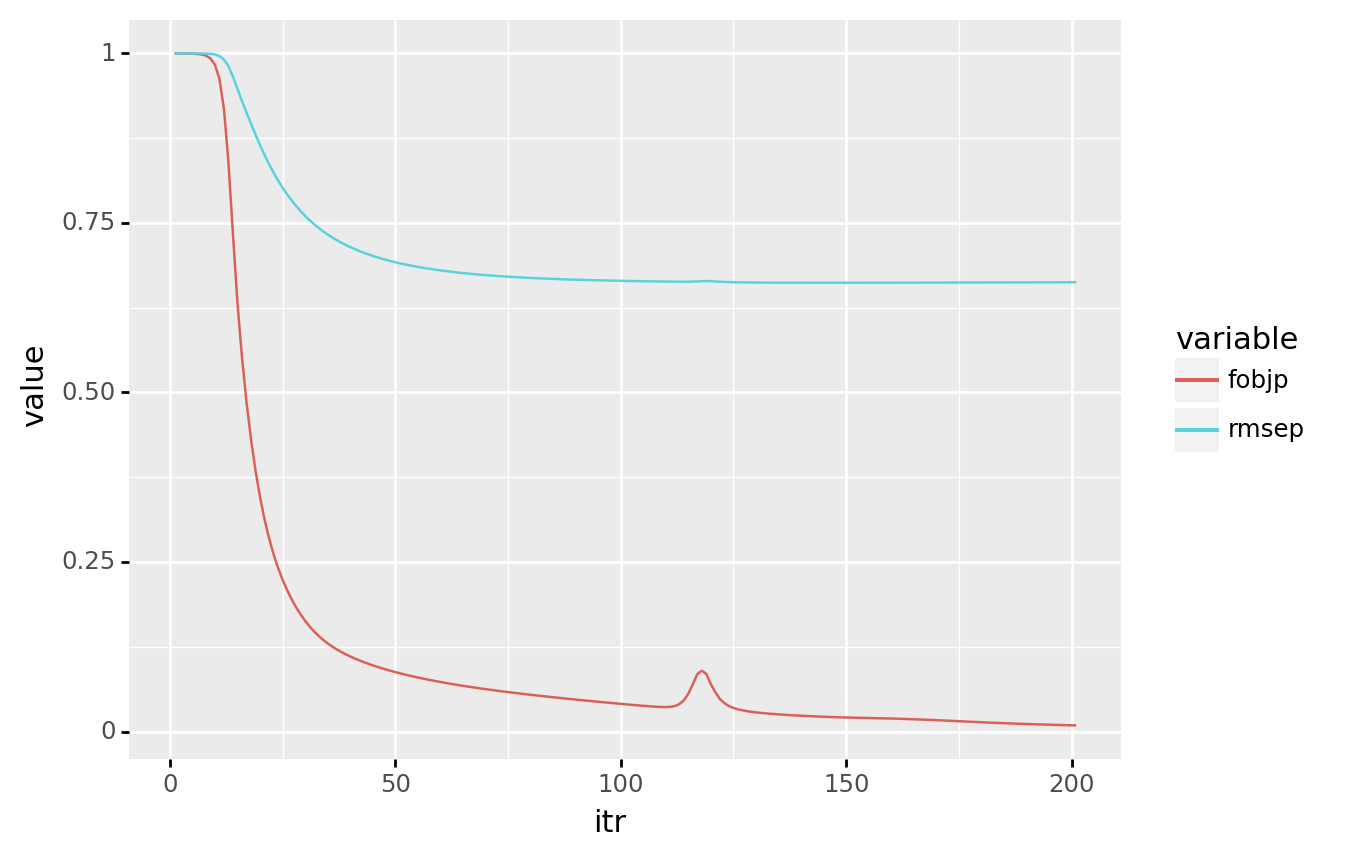

<ggplot: (132033857074)>


In [22]:
print(ggplot(path1gg, aes('itr', 'value', color = 'variable')) + geom_line())

In [23]:
# Create a rating based on time played after gradient descent

def game_hrs_density_p(pred, GAME=None, nclass=1, print_vals=True):
    
    game_dict = dict(games.values)
    t_GAME = GAME
    if not GAME:
        GAME = np.random.randint(0, games.shape[0])
    else:
        GAME = game_dict[GAME]
    game_data = pd.Series(pred[:, GAME])
    game_data = game_data[game_data > 0]

    # EM algorithm
    mu_init = np.linspace(min(game_data), max(game_data), nclass).reshape(-1, 1)
    sigma_init = np.array([1] * nclass).reshape(-1, 1, 1)
    gaussian = GaussianMixture(n_components=nclass, means_init=mu_init, precisions_init=sigma_init).fit(game_data.values.reshape([-1, 1]))
    if print_vals:
        print(' lambda: {}\n mean: {}\n sigma: {}\n'.format(gaussian.weights_, gaussian.means_, gaussian.covariances_))
    
    # building data frame for plotting
    x = np.linspace(min(game_data), max(game_data), 1000)
    dens = pd.DataFrame({'x': x})
    for i in range(nclass):
        dens['y{}'.format(i+1)] = gaussian.weights_[i]* scipy.stats.norm(gaussian.means_[i][0], gaussian.covariances_[i][0][0]).pdf(x)
    dens = dens.melt('x', value_name='gaussian')
    game_data = pd.DataFrame(game_data, columns=['game_daat'])
    game_plt = ggplot(aes(x='game_data', y='stat(density)'), game_data) + geom_histogram(bins=45, colour = "black", alpha = 0.7, size = 0.1) + \
               geom_area(dens, aes(x='x', y='gaussian', fill = 'variable'), alpha = 0.5, position = position_dodge(width=0.2)) + geom_density()+ \
               ggtitle(t_GAME)
    return game_plt

 lambda: [2.84770668e-01 4.62561495e-01 2.32156013e-01 2.00801516e-02
 4.31671414e-04]
 mean: [[0.73293346]
 [2.52714757]
 [4.18019913]
 [6.27829051]
 [9.47888225]]
 sigma: [[[0.28165629]]

 [[0.86812443]]

 [[0.64641101]]

 [[0.69642771]]

 [[0.1985051 ]]]



C:\Users\HP\anaconda3\envs\metis\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_dodge requires non-overlapping x intervals


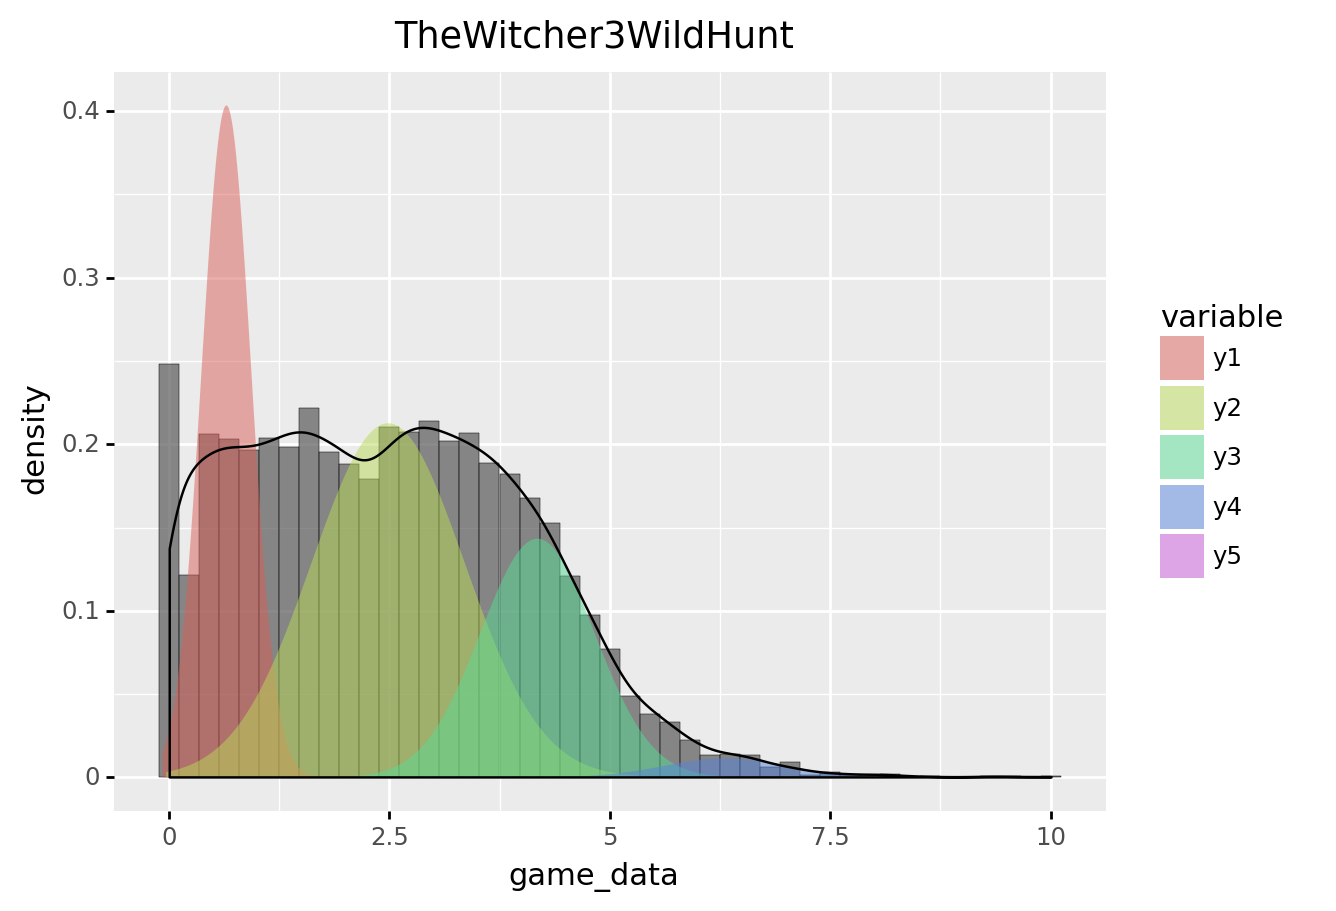

<ggplot: (132033567629)>


In [24]:
a = game_hrs_density_p(pred, "TheWitcher3WildHunt", 5)
print(a)

In [25]:
# Export recommend games
user_dict = dict(users.values)
game_dict = {games.iloc[i, 0]: games.iloc[i, 1] for i in range(games.shape[0])}
I_pred = np.zeros_like(I)
for i in range(df.shape[0]):
    line = df.iloc[i]
    if line['user'] in user_dict and line['game1'] in game_dict:
        I_pred[user_dict[line['user']], game_dict[line['game1']]] = 1

In [26]:
reverse_game_dict = {games.iloc[i, 1]: games.iloc[i, 0] for i in range(games.shape[0])}
pred_percentile = pd.DataFrame(pred)
for col in pred_percentile.columns:
    pred_percentile[col] = pred_percentile[col].rank(pct=True)
pred_percentile = pred_percentile.values

In [27]:
def top(n, user, print_value=True):
    #Not consider the games has been purchsed
    not_purchased = (I - 1) % 2
    t_user = user
    user = user_dict[user]
    top_games = (pred_percentile*not_purchased).iloc[user]
    top_games = list(top_games.sort_values(ascending=False)[:20].index)
    #For test
    if print_value:
        print('top {} recommended games for user {}: '.format(n, t_user))
        for i in range(n):
            print(i, ")", reverse_game_dict[top_games[i]])
    else:
        result = [t_user]
        for i in range(n):
            result.append(reverse_game_dict[top_games[i]])
        return result
#top(20, 5250)

In [28]:
top_N = 10
result = []
users_merge=pd.merge(users_test,users_train,on='user',how='inner')
for idx, user in tqdm(enumerate(users_merge['user'].values)):
    result.append(top(top_N, user, False))

users_not=users_test[~users_test['user'].isin(users_merge['user'])]
for user in users_not['user']:
    empty=[user]
    for i in range(10):
        empty.append(0)
    result.append(empty)
result = pd.DataFrame(result)
columns = ['user'] + ['{}'.format(i+1) for i in range(top_N)]
result.columns = columns
result.to_csv(r'C:\Users\HP\Metis\my_fourth_project\Collaborative_EM_output_10.csv', index=None)

3417it [05:12, 10.95it/s]


In [29]:
result

,user,1,2,3,4,5,6,7,8,9,10
0,5250,DontStarve,StarTrekOnline,CallofDutyModernWarfare2Multiplayer,Starbound,TheWolfAmongUs,DeadSpace,XCOMEnemyUnknown,Neverwinter,MagickaWizardWars,InfestationSurvivorStories
1,76767,RedFactionGuerrillaSteamEdition,TheBindingofIsaac,SidMeiersCivilizationV,DarkSoulsPreparetoDieEdition,Audiosurf,7DaystoDie,DeusExHumanRevolution,TheElderScrollsVSkyrim,SidMeiersCivilizationIV,Trine2
2,86540,DontStarve,DayofDefeatSource,Audiosurf,DontStarveTogetherBeta,SpaceEngineers,BioShock,Metro2033,MedievalIITotalWar,JustCause2,CompanyofHeroesNewSteamVersion
3,229911,Left4Dead,SpaceEngineers,APBReloaded,MountBladeWarband,OrcsMustDie,SaintsRow2,StarWarsKnightsoftheOldRepublic,TheWitcher2AssassinsofKingsEnhancedEdition,WaroftheRoses,DragonAgeOriginsUltimateEdition
4,298950,HeroesGenerals,Audiosurf,ChivalryMedievalWarfare,Spore,StarWarsKnightsoftheOldRepublic,WaroftheRoses,OrcsMustDie,Fallout3GameoftheYearEdition,ArcheAge,SimCity4Deluxe
...,...,...,...,...,...,...,...,...,...,...,...
5843,309213952,0,0,0,0,0,0,0,0,0,0
5844,309262440,0,0,0,0,0,0,0,0,0,0
5845,309265377,0,0,0,0,0,0,0,0,0,0
5846,309434439,0,0,0,0,0,0,0,0,0,0
